# *Capstone by Shivank Vatsal*
#### Note: Maps are Not Viewable in This Notebook Due to Size Constraints (Please Refer to Report)

## Key Points
* [Data Collection](#data)
* [Accessing Foursquare API](#foursquare)
* [One-Hot Encoding](#onehot)
* [KMeans Clustering](#kmeans)
* [DBSCAN Algorithm](#dbscan)
* [Cluster Labeling](#labeling)
* [Choropleth Map with Popups](#map)

# Data Collection <a name="data"></a>
## Import Necessary Modules

In [1]:
import os, sys
import numpy as np
import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

from sklearn import metrics 
from scipy.spatial.distance import cdist 
from bs4 import BeautifulSoup
import json
from geopy.geocoders import Nominatim 
import requests
from pandas.io.json import json_normalize 
from sklearn.cluster import DBSCAN 
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import normalize 
from sklearn.decomposition import PCA 

import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt  

from sklearn.cluster import KMeans
import folium

In [2]:
# @hidden_cell

## Import GeoJSON File

In [3]:
from ibm_botocore.client import Config
import ibm_boto3

cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])

In [4]:
cos.download_file(Bucket=credentials['BUCKET'],Key='texascounties.json',Filename='texascounties.json')

In [5]:
with open('texascounties.json') as json_data:
    geo_data = json.load(json_data)

In [ ]:
tcounties_data = geo_data['features']
tcounties_data[0]

## Transform JSON into Dataframe: Counties and Coordinates

In [7]:
column_names = ['County', 'Latitude', 'Longitude'] 
counties = pd.DataFrame(columns = column_names)
for data in tcounties_data:
    county_name = data['properties']['namelsad']
    county_lat = data['properties']['intptlat']
    county_lon = data['properties']['intptlon']
    
    counties = counties.append({'County': county_name,
                                          'Latitude': county_lat,
                                          'Longitude': county_lon}, ignore_index=True)
counties.head()

,County,Latitude,Longitude
0,Menard County,+30.8843655,-099.8539896
1,Calhoun County,+28.4417191,-096.5795739
2,Hale County,+34.0684364,-101.8228879
3,Kerr County,+30.0599530,-099.3533388
4,Armstrong County,+34.9641790,-101.3566363


## Clean Data

In [8]:
counties['Longitude'] = counties['Longitude'].apply(lambda x : x.replace('0', '', 1) if x.startswith("-0") else x)
counties['Latitude'] = counties['Latitude'].apply(lambda x : x[1:] if x.startswith("+") else x)
counties.head()

,County,Latitude,Longitude
0,Menard County,30.8843655,-99.8539896
1,Calhoun County,28.4417191,-96.5795739
2,Hale County,34.0684364,-101.8228879
3,Kerr County,30.0599530,-99.3533388
4,Armstrong County,34.9641790,-101.3566363


## Web Scraping HTML to Collect Population Data

In [9]:
pop_url = "https://www.texas-demographics.com/counties_by_population"
data = []
r = requests.get(pop_url)
code = BeautifulSoup(r.text, 'html.parser')
rank_table = code.find('table', class_ = 'ranklist')

if rank_table is not None:
    rows = rank_table.find_all('tr')
    for tr in rows:
        cols = tr.find_all('td')
        for td in cols:
            data.append(td.text.strip())

## Clean Data

In [ ]:
index = data.index('Loving County') + 2
data = data[:index]
del data[::3]
print(data)

In [11]:
data = np.array(data)
data = np.reshape(data, (-1, 2))

## Transform into Dataframe: County and Population

In [12]:
column_names = ['County', 'Population'] 
counties_pop = pd.DataFrame(data = data, columns = column_names)
counties_pop.head()

,County,Population
0,Harris County,"4,646,630"
1,Dallas County,"2,606,868"
2,Tarrant County,"2,049,770"
3,Bexar County,"1,952,843"
4,Travis County,"1,226,805"


## Merge Population and Location Data

In [13]:
counties = counties.merge(counties_pop, on = 'County', how = 'left')
counties = counties.dropna()
counties.head()

,County,Latitude,Longitude,Population
0,Menard County,30.8843655,-99.8539896,"2,119"
1,Calhoun County,28.4417191,-96.5795739,"21,668"
2,Hale County,34.0684364,-101.8228879,"33,826"
3,Kerr County,30.0599530,-99.3533388,"51,843"
4,Armstrong County,34.9641790,-101.3566363,"1,973"


In [14]:
# @hidden_cell

## Import Excel Data: Fastest Growing Cities in Texas + Sociodemographic Rank

In [15]:
cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])
cos.download_file(Bucket=credentials['BUCKET'],Key='fastgrowingtex.xlsx',Filename='fastgrowingtex.xlsx')
data = pd.read_excel('fastgrowingtex.xlsx', dtype = str)
data.head()

,City,County,Sociodemographic Rank
0,Frisco,Denton County,2
1,Round Rock,Williamson County,13
2,McKinney,Collin County,8
3,Sugar Land,Fort Bend County,4
4,Midland,Midland County,22


## Merge/Clean All Data

In [16]:
data = data.rename(columns = {"Sociodemographic Rank": "SD Rank"})
counties = counties.merge(data, on = 'County', how = 'left')
counties = counties.dropna()
counties.head()

,County,Latitude,Longitude,Population,City,SD Rank
12,Jefferson County,29.8539997,-94.1493306,"254,340",Beaumont,408
14,Brazos County,30.6567174,-96.3023920,"222,981",College Station,20
15,Brazos County,30.6567174,-96.3023920,"222,981",Bryan,216
16,Bell County,31.0423032,-97.4813742,"348,574",Killeen,86
18,Hidalgo County,26.3963839,-98.1809900,"855,176",Edinburg,16


## Define Function to Locate Coordinates of Cities

In [17]:
def avgcoord(col):
    lats = []
    longs = []
    cits = []
    print('Locating: ')
    for city in col:
        cits.append(city)
        address = '{}, TX'.format(city)
        geolocator = Nominatim(user_agent = "tex")
        location = geolocator.geocode(address)
        longs.append(location.longitude) 
        lats.append(location.latitude)

    coords = pd.DataFrame(list(zip(cits, lats, longs)), columns =['City', 'CityLat', 'CityLong']) 
    return(coords)

coords = avgcoord(col = counties['City'])
coords.head()

Locating: 


,City,CityLat,CityLong
0,Beaumont,30.086046,-94.101846
1,College Station,30.595529,-96.307104
2,Bryan,30.674364,-96.369963
3,Killeen,31.117144,-97.727796
4,Edinburg,26.301398,-98.162450


## Merge/Clean Data

In [18]:
counties["SD Rank"] = pd.to_numeric(counties["SD Rank"])
counties = counties.groupby(['County', 'Latitude', 'Longitude', 'Population'], as_index = False).agg({'City': ', '.join, 'SD Rank': np.mean})
counties['SD Rank'] = counties['SD Rank'].rank(method='max')
counties = counties.astype({'SD Rank': 'int'})
counties.head()

,County,Latitude,Longitude,Population,City,SD Rank
0,Bell County,31.0423032,-97.4813742,"348,574",Killeen,8
1,Bexar County,29.4486708,-98.5201465,"1,952,843",San Antonio,14
2,Brazoria County,29.1678175,-95.4346470,"360,677",Pearland,1
3,Brazos County,30.6567174,-96.3023920,"222,981","College Station, Bryan",11
4,Cameron County,26.1029227,-97.4789584,"421,666",Brownsville,25


In [19]:
# @hidden_cell

## Import Excel Data: Median House Price by County

In [20]:
cos = ibm_boto3.client(service_name='s3',
    ibm_api_key_id=credentials['IBM_API_KEY_ID'],
    ibm_service_instance_id=credentials['IAM_SERVICE_ID'],
    ibm_auth_endpoint=credentials['IBM_AUTH_ENDPOINT'],
    config=Config(signature_version='oauth'),
    endpoint_url=credentials['ENDPOINT'])
cos.download_file(Bucket=credentials['BUCKET'],Key='housepricestex.xlsx',Filename='housepricestex.xlsx')
data = pd.read_excel('housepricestex.xlsx')
data.head()

,Unnamed: 0,County,Unnamed: 2,Median House Price
0,NaN,Bell County,NaN,203000
1,NaN,Collin County,NaN,365000
2,NaN,Dallas County,NaN,280000
3,NaN,Denton County,NaN,340000
4,NaN,Ector County,NaN,232500


## Merge/Clean Data

In [21]:
data = data.rename(columns = {"Median House Price": "$MHP"})
data = data[['County', '$MHP']]
data = data.dropna()
data = data.astype({'County': 'str'})
data['County'] = data['County'].apply(lambda x: x.strip())
data.head()

,County,$MHP
0,Bell County,203000
1,Collin County,365000
2,Dallas County,280000
3,Denton County,340000
4,Ector County,232500


In [ ]:
counties = counties.merge(data, on = 'County', how = 'left')
counties = counties.dropna()
counties = counties.rename(columns = {"City": "Cities"})
counties['$MHP'][24] = counties['$MHP'][24][:7].replace(',', '')
counties.head()

## Use Folium to Visualize Results So Far

In [23]:
address = 'Austin, TX, United States'
geolocator = Nominatim(user_agent = "texas")
location = geolocator.geocode(address)
longitude = location.longitude
latitude = location.latitude
print('Capital Coordinates: {}, {}'.format(latitude, longitude))

map_tex = folium.Map(location = [latitude, longitude], zoom_start = 6)
for lat, lng, cit, cnt in zip(counties['Latitude'], counties['Longitude'], counties['County'], counties['Cities']):
    label = '{}: {}'.format(cnt, cit)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, lng], 
    radius = 5, 
    popup = label, 
    color = 'red', 
    parse_html = False).add_to(map_tex)
    
map_tex

Capital Coordinates: 30.2711286, -97.7436995


In [24]:
# @hidden_cell

## Access Foursquare API: Get Venue Data for Cities <a name="foursquare"></a>

In [25]:
def getNearbyVenues(names, latitudes, longitudes, radius = 1200):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):   
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['City', 
                  'City Latitude', 
                  'City Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [26]:
texas_venues = getNearbyVenues(names = coords['City'], latitudes = coords['CityLat'], longitudes = coords['CityLong'])
print(texas_venues.shape)
texas_venues.head()

(1899, 7)


,City,City Latitude,City Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Beaumont,30.086046,-94.101846,Chuck's Sandwich Shop,30.083338,-94.098401,Sandwich Place
1,Beaumont,30.086046,-94.101846,New York Pizza & Pasta,30.079182,-94.098843,Italian Restaurant
2,Beaumont,30.086046,-94.101846,Suga's Deep South Cuisine & Jazz Bar,30.082036,-94.099585,Café
3,Beaumont,30.086046,-94.101846,Jefferson Theatre,30.082020,-94.097720,Theater
4,Beaumont,30.086046,-94.101846,Green Light Kitchen,30.085161,-94.097517,Café


## One Hot Encoding Venues in Preparation for Clustering <a name="onehot"></a>

In [ ]:
texonehot = pd.get_dummies(texas_venues[['Venue Category']], prefix="", prefix_sep="")
texonehot['City'] = texas_venues['City'] 
cit = texonehot['City']
texonehot.drop(labels = ['City'], axis = 1, inplace = True)
texonehot.insert(0, 'City', cit)
texonehot.head()

## Identifying Most Common Venues By City

In [28]:
texmean = texonehot.groupby('City').mean().reset_index()

def most_common(row, rank):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:rank]

In [29]:
rank = 10
suffix = ['st', 'nd', 'rd']
columns = ['City']
for ind in np.arange(rank):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, suffix[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

vensort = pd.DataFrame(columns=columns)
vensort['City'] = texmean['City']

for ind in np.arange(texmean.shape[0]):
    vensort.iloc[ind, 1:] = most_common(texmean.iloc[ind, :], rank)

vensort.head()

,City,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abilene,Grocery Store,Mexican Restaurant,Toy / Game Store,Gas Station,Chinese Restaurant,Thrift / Vintage Store,Fast Food Restaurant,Candy Store,Tree,Pizza Place
1,Allen,Fast Food Restaurant,Mexican Restaurant,Pharmacy,Mediterranean Restaurant,BBQ Joint,Café,Gym / Fitness Center,Sandwich Place,Convenience Store,Asian Restaurant
2,Amarillo,Bar,American Restaurant,Sushi Restaurant,Restaurant,Sandwich Place,Hockey Arena,Convention Center,Café,Grocery Store,Gay Bar
3,Arlington,Vietnamese Restaurant,Mexican Restaurant,Park,Grocery Store,Discount Store,Sandwich Place,Fast Food Restaurant,Asian Restaurant,Miscellaneous Shop,Insurance Office
4,Austin,Coffee Shop,Hotel,Bar,Cocktail Bar,New American Restaurant,Lounge,Juice Bar,Movie Theater,Yoga Studio,Italian Restaurant


## Elbow Method to Distinguish Optimal K-Value for KMeans Clustering <a name="kmeans"></a>

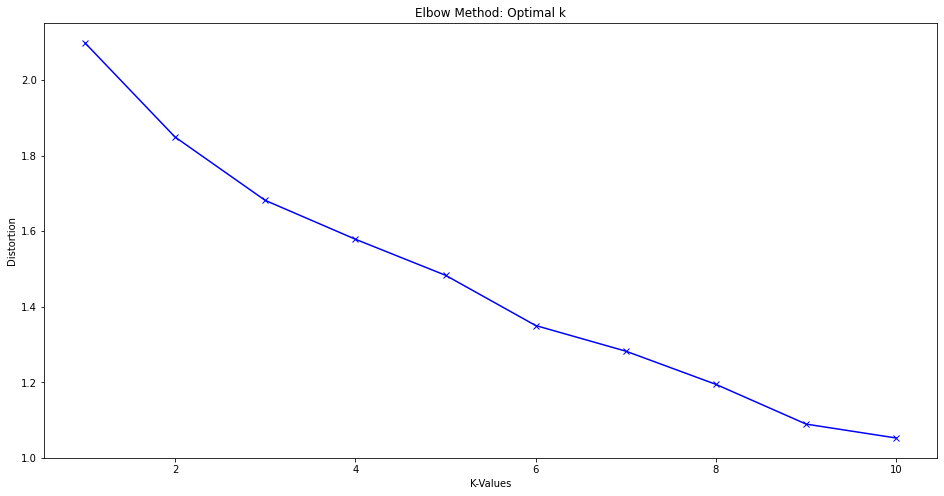

In [30]:
texk = texmean.drop('City', axis = 1)

distortions = []
K = range(1,11)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(texk)
    distortions.append(kmeanModel.inertia_)
    
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('K-Values')
plt.ylabel('Distortion')
plt.title('Elbow Method: Optimal k')
plt.show()

## No Distinguishable K Value/Elbow --> Use DBSCAN Algorithm for Clustering <a name="dbscan"></a>

In [31]:
pca = PCA(n_components = 2) 
texdb = pca.fit_transform(texk) 
texdb = pd.DataFrame(texdb) 
texdb.columns = ['1', '2'] 
texdb.head()

,1,2
0,-0.024056,0.025028
1,0.010091,0.008420
2,0.030610,-0.074525
3,-0.050538,0.063337
4,0.050510,-0.075062


## DBSCAN: Estimate Epsilon Value and Label Clusters

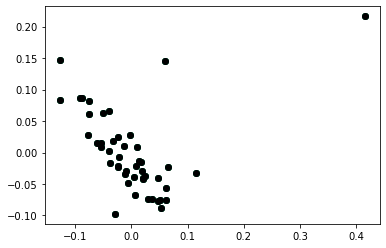

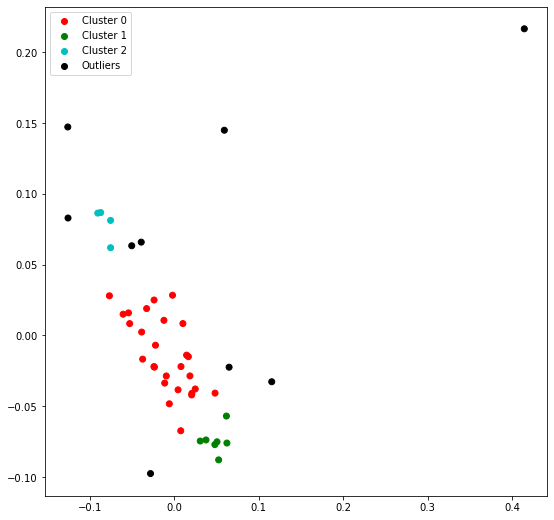

In [32]:
db_default = DBSCAN(eps = 0.02377, min_samples = 4).fit(texdb) 
labels = db_default.labels_ 

colors = {} 
colors[0] = 'r'
colors[1] = 'g'
colors[2] = 'c'
colors[-1] = 'k'

cvec = [colors[label] for label in labels] 
r = plt.scatter(texdb['1'], texdb['2'], color ='r'); 
g = plt.scatter(texdb['1'], texdb['2'], color ='g'); 
c = plt.scatter(texdb['1'], texdb['2'], color ='c');  
k = plt.scatter(texdb['1'], texdb['2'], color ='k'); 
plt.figure(figsize =(9, 9)) 
plt.scatter(texdb['1'], texdb['2'], c = cvec)  
plt.legend((r, g, c, k), ('Cluster 0', 'Cluster 1', 'Cluster 2', 'Outliers')) 
  
plt.show() 

## Merging Cluster Data 

In [33]:
final = vensort
final.insert(1, 'Cluster', labels)

In [34]:
final = coords.merge(final, on = 'City', how = 'left')
final.head()

,City,CityLat,CityLong,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Beaumont,30.086046,-94.101846,1,Café,American Restaurant,Nightclub,Sandwich Place,Bar,Theater,Museum,Gay Bar,Other Repair Shop,Boutique
1,College Station,30.595529,-96.307104,0,Hotel,Chinese Restaurant,Pizza Place,Bakery,Japanese Restaurant,Liquor Store,Business Service,Burger Joint,Fried Chicken Joint,Storage Facility
2,Bryan,30.674364,-96.369963,0,Mexican Restaurant,Hot Dog Joint,Bar,Fried Chicken Joint,Burger Joint,Fast Food Restaurant,BBQ Joint,Pizza Place,Sandwich Place,Café
3,Killeen,31.117144,-97.727796,0,Fast Food Restaurant,Korean Restaurant,Chinese Restaurant,Pizza Place,Cosmetics Shop,BBQ Joint,Mobile Phone Shop,Mexican Restaurant,Flower Shop,Grocery Store
4,Edinburg,26.301398,-98.162450,2,Mexican Restaurant,Convenience Store,Seafood Restaurant,Discount Store,Bakery,Burger Joint,Fried Chicken Joint,Sandwich Place,Chinese Restaurant,Performing Arts Venue


## Re-Merging County and SD Rank

In [ ]:
data = pd.read_excel('fastgrowingtex.xlsx', dtype = str)
data

In [36]:
final = data.merge(final, on = 'City', how = 'left')

In [37]:
final.head()

,City,County,Sociodemographic Rank,CityLat,CityLong,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Frisco,Denton County,2,33.150674,-96.823612,0.0,Mexican Restaurant,Thai Restaurant,American Restaurant,Art Gallery,Dessert Shop,Pool,Farmers Market,Smoke Shop,Steakhouse,Sports Bar
1,Round Rock,Williamson County,13,30.508235,-97.678893,0.0,American Restaurant,Pizza Place,Gas Station,Bar,Coffee Shop,Bakery,Grocery Store,Burger Joint,Ice Cream Shop,Mexican Restaurant
2,McKinney,Collin County,8,33.197650,-96.615447,0.0,American Restaurant,Mexican Restaurant,Café,Food,Discount Store,Farmers Market,Sandwich Place,Bakery,Steakhouse,Burger Joint
3,Sugar Land,Fort Bend County,4,29.619679,-95.634946,-1.0,Park,Intersection,Food Truck,Auto Workshop,Office,Gas Station,Other Great Outdoors,Big Box Store,Clothing Store,Gym
4,Midland,Midland County,22,31.997366,-102.077948,0.0,Mexican Restaurant,Bar,Ice Cream Shop,Sandwich Place,Convenience Store,Gym,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store


In [38]:
final = final.rename(columns = {"Sociodemographic Rank": "SD Rank"})

## Assigning Relative SD Rank Within Data

In [39]:
final["SD Rank"] = pd.to_numeric(final["SD Rank"])
final['SD Rank'] = final['SD Rank'].rank(method='max')
final = final.astype({'SD Rank': 'int'})
final.dropna()
print(final.shape)
final.head()

(48, 16)


,City,County,SD Rank,CityLat,CityLong,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Frisco,Denton County,1,33.150674,-96.823612,0.0,Mexican Restaurant,Thai Restaurant,American Restaurant,Art Gallery,Dessert Shop,Pool,Farmers Market,Smoke Shop,Steakhouse,Sports Bar
1,Round Rock,Williamson County,5,30.508235,-97.678893,0.0,American Restaurant,Pizza Place,Gas Station,Bar,Coffee Shop,Bakery,Grocery Store,Burger Joint,Ice Cream Shop,Mexican Restaurant
2,McKinney,Collin County,3,33.197650,-96.615447,0.0,American Restaurant,Mexican Restaurant,Café,Food,Discount Store,Farmers Market,Sandwich Place,Bakery,Steakhouse,Burger Joint
3,Sugar Land,Fort Bend County,2,29.619679,-95.634946,-1.0,Park,Intersection,Food Truck,Auto Workshop,Office,Gas Station,Other Great Outdoors,Big Box Store,Clothing Store,Gym
4,Midland,Midland County,10,31.997366,-102.077948,0.0,Mexican Restaurant,Bar,Ice Cream Shop,Sandwich Place,Convenience Store,Gym,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store


In [40]:
final = final.dropna()

## Merging House Price Data and GeoJSON for Choropleth Map

In [ ]:
prices = counties[['County', '$MHP']].copy()
prices.reset_index(inplace=True)
prices.drop(labels = ['index'], axis = 1, inplace = True)
prices = prices.astype({'$MHP': 'int'})
prices = prices.astype({'County': 'str'})
prices

## Visualizing Median House Prices by County with Choropleth Map

In [ ]:
finmap = folium.Map(location = [30.2711286, -97.7436995], zoom_start = 7)
finmap.choropleth(
 geo_data=geo_data,
 name='choropleth',
 data=prices,
 columns=['County', '$MHP'],
 key_on='feature.properties.namelsad',
 fill_color='YlGn',
 fill_opacity=0.7,
 line_opacity=0.2,
 legend_name='Median Housing Price'
)
folium.LayerControl().add_to(finmap)
 
finmap

## Manipulating Cluster Values for Cluster Labeling

In [43]:
cluslab = final[['City', 'Cluster']].copy()
cluslab.head()

,City,Cluster
0,Frisco,0.0
1,Round Rock,0.0
2,McKinney,0.0
3,Sugar Land,-1.0
4,Midland,0.0


In [44]:
cluslab = cluslab.merge(texmean, on = 'City', how = 'left')

In [45]:
cluslab = cluslab.astype({'Cluster': 'int'})
cluslab = cluslab.astype({'Cluster': 'str'})
cluslab.drop(labels = ['City'], axis = 1, inplace = True)
cluslab.head()

,Cluster,Accessories Store,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Assisted Living,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Café,Cajun / Creole Restaurant,Candy Store,Capitol Building,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Auditorium,Comedy Club,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Creperie,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store,Empanada Restaurant,Fabric Shop,Farmers Market,Fast Food Restaurant,Field,Fishing Spot,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hockey Arena,Home Service,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Lighting Store,Liquor Store,Locksmith,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motel,Motorcycle Shop,Motorsports Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Notary,Office,Optical Shop,Other Great Outdoors,Other Repair Shop,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Post Office,Print Shop,Pub,Public Art,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rest Area,Restaurant,Rock Club,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train Station,Transportation Service,Travel & Transport,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo
0,0,0.0,0.051282,0.000000,0.0,0.0,0.051282,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.025641,0.0,0.0,0.0,0.0,0.000000,0.000000,0.025641,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.025641,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.025641,0.0,0.0,0.0,0.0,0.051282,0.025641,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0

In [ ]:
tags = cluslab[['Cluster']]
tags['Cluster'] = tags['Cluster'].apply(lambda x : x.replace(x, 'Outlier') if x.startswith("-1") else x)
tags['Cluster'] = tags['Cluster'].apply(lambda x : x.replace(x, 'Cluster {}'.format(x)))
tags.head()

## Aggregating Venue Frequency By Cluster for Labeling

In [47]:
cluslab.drop(labels = ['Cluster'], axis = 1, inplace = True)
cluslab.insert(0, 'Cluster', tags)
cluslab = cluslab.groupby(['Cluster']).agg('sum')
cluslab

,Accessories Store,American Restaurant,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Assisted Living,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Shop,Bistro,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Café,Cajun / Creole Restaurant,Candy Store,Capitol Building,Caribbean Restaurant,Check Cashing Service,Chinese Restaurant,Chocolate Shop,Church,Clothing Store,Cocktail Bar,Coffee Shop,College Auditorium,Comedy Club,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Creperie,Cupcake Shop,Cycle Studio,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dumpling Restaurant,Electronics Store,Empanada Restaurant,Fabric Shop,Farmers Market,Fast Food Restaurant,Field,Fishing Spot,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Truck,Football Stadium,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gymnastics Gym,Hardware Store,Health & Beauty Service,Historic Site,History Museum,Hockey Arena,Home Service,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Lighting Store,Liquor Store,Locksmith,Lounge,Market,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motel,Motorcycle Shop,Motorsports Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Notary,Office,Optical Shop,Other Great Outdoors,Other Repair Shop,Paper / Office Supplies Store,Park,Pedestrian Plaza,Performing Arts Venue,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pizza Place,Platform,Playground,Plaza,Pool,Pool Hall,Post Office,Print Shop,Pub,Public Art,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rest Area,Restaurant,Rock Club,Russian Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Science Museum,Seafood Restaurant,Shanghai Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South American Restaurant,Southern / Soul Food Restaurant,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Storage Facility,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tanning Salon,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theater,Theme Park Ride / Attraction,Theme Restaurant,Thrift / Vintage Store,Tourist Information Center,Toy / Game Store,Trail,Train Station,Transportation Service,Travel & Transport,Tree,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wings Joint,Women's Store,Yoga Studio,Zoo
Cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Cluster 0,0.0000,0.755814,0.129989,0.00,0.095245,0.165962,0.046129,0.026974,0.058232,0.000000,0.047619,0.047619,0.092503,0.149079,0.601460,0.02439,0.316827,0.268110,0.884269,0.131030,0.000000,0.017857,0.00,0.00,0.033787,0.00,0.11256

In [48]:
cluslab = cluslab.T
cluslab = cluslab.reset_index()

In [49]:
cluslab.head()

Cluster,index,Cluster 0,Cluster 1,Cluster 2,Cluster Outlier
0,Accessories Store,0.000000,0.000000,0.062500,0.000000
1,American Restaurant,0.755814,0.277387,0.052632,0.142857
2,Antique Shop,0.129989,0.000000,0.000000,0.000000
3,Aquarium,0.000000,0.010000,0.000000,0.000000
4,Arcade,0.095245,0.000000,0.000000,0.000000


## Plotting Venue Frequencies by Cluster for Labeling <a name="labeling"></a>
### Cluster 0

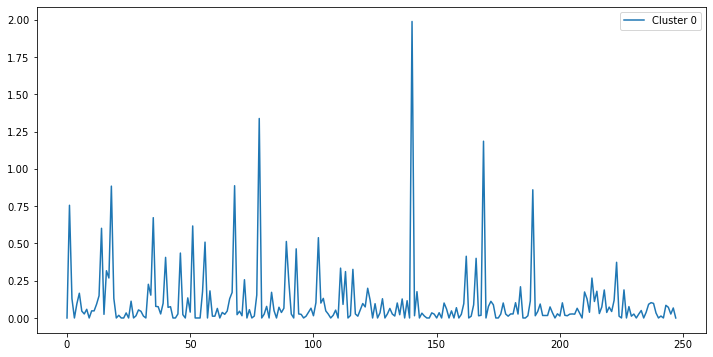

In [50]:
cluslab['Cluster 0'].plot(legend=True, figsize=(12,6))  
plt.show()

### Cluster 1

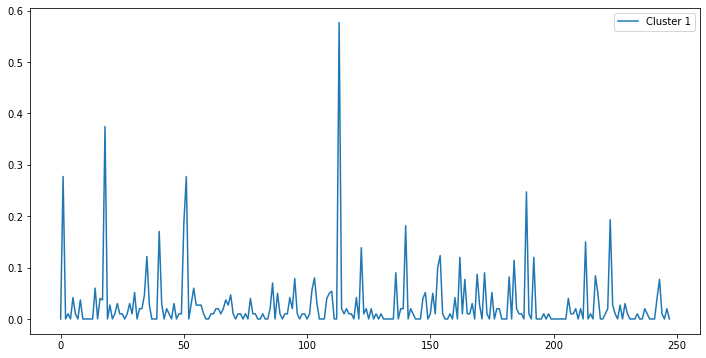

In [51]:
cluslab['Cluster 1'].plot(legend=True, figsize=(12,6))  
plt.show()

### Cluster 2

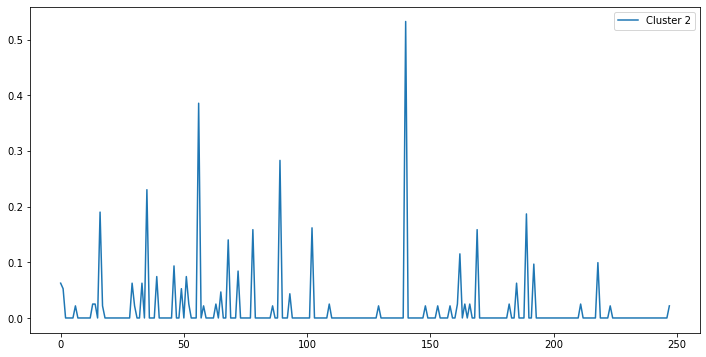

In [52]:
cluslab['Cluster 2'].plot(legend=True, figsize=(12,6))  
plt.show()

## Filtering Common Venue Categories for Labeling

In [53]:
clus0 = cluslab[['Cluster 0', 'index']]
clus1 = cluslab[['Cluster 1', 'index']]
clus2 = cluslab[['Cluster 2', 'index']]

### Cluster 0: Fast Food and Mexican Cuisine

In [54]:
clus0 = clus0[clus0['Cluster 0'] > 1]
clus0

Cluster,Cluster 0,index
78,1.337932,Fast Food Restaurant
140,1.988521,Mexican Restaurant
169,1.185461,Pizza Place


### Cluster 1: Hotel and Social Venues

In [55]:
clus1 = clus1[clus1['Cluster 1'] > 0.3]
clus1

Cluster,Cluster 1,index
18,0.374414,Bar
113,0.577027,Hotel


### Cluster 2: Convenience Stores and Mexican Cuisine

In [56]:
clus2 = clus2[clus2['Cluster 2'] > 0.3]
clus2

Cluster,Cluster 2,index
56,0.385612,Convenience Store
140,0.532437,Mexican Restaurant


## Referencing Final Dataframe for Visualization

In [57]:
final = final.astype({'Cluster': 'int'})
# final['Cluster'] = final['Cluster'].apply(lambda x : x.replace(x, 'Outlier') if x.startswith("-1") else x)
final.head()

,City,County,SD Rank,CityLat,CityLong,Cluster,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Frisco,Denton County,1,33.150674,-96.823612,0,Mexican Restaurant,Thai Restaurant,American Restaurant,Art Gallery,Dessert Shop,Pool,Farmers Market,Smoke Shop,Steakhouse,Sports Bar
1,Round Rock,Williamson County,5,30.508235,-97.678893,0,American Restaurant,Pizza Place,Gas Station,Bar,Coffee Shop,Bakery,Grocery Store,Burger Joint,Ice Cream Shop,Mexican Restaurant
2,McKinney,Collin County,3,33.197650,-96.615447,0,American Restaurant,Mexican Restaurant,Café,Food,Discount Store,Farmers Market,Sandwich Place,Bakery,Steakhouse,Burger Joint
3,Sugar Land,Fort Bend County,2,29.619679,-95.634946,-1,Park,Intersection,Food Truck,Auto Workshop,Office,Gas Station,Other Great Outdoors,Big Box Store,Clothing Store,Gym
4,Midland,Midland County,10,31.997366,-102.077948,0,Mexican Restaurant,Bar,Ice Cream Shop,Sandwich Place,Convenience Store,Gym,Tex-Mex Restaurant,Thai Restaurant,Theater,Thrift / Vintage Store


## Summarized Visual: Choropleth and Color-Coded Cities <a name="map"></a>

In [ ]:
import matplotlib.cm as cm
import matplotlib.colors as colors

def get_string(num):
    if num == -1:
        clus = 'Outlier'
    else:
        clus = str(num)
    return clus

def get_desc(num):
    desc = ''
    if num == 0:
        desc = 'Fast Food and Mexican Cuis.'
        return desc
    elif num == 1:
        desc = 'Hotel and Social Venues'
        return desc
    elif num == 2:
        desc = 'Conv. Store and Mexican Cuis.'
        return desc
    else:
        return desc

clusters = 4
x = np.arange(clusters)
ys = [i + x + (i*x)**2 for i in range(clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cit, cty, cluster, rank in zip(final['CityLat'], final['CityLong'], final['City'], final['County'], final['Cluster'], final['SD Rank']):
    label = folium.Popup(str(cit) + ', ' + str(cty) + '| ' + 'Cluster ' + get_string(cluster) + ': ' + str(get_desc(cluster)) + '| ' + 'SD Rank: ' + str(rank), parse_html=True, max_width=300, min_width=300)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1] if cluster > -1 else 'black',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(finmap)
       
finmap

## End of Notebook